# Artificial Intelligence for Equipment Failure Prediction

*Epolatory Data Analysis*

## 1. Data Overview & Basic Statics

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import sys
import os
# Set working directory to project root (if needed)
os.chdir('../')  # Go up one level if notebook is in subfolder

# Import your custom functions
from utils.preprocess import load_nasa_data, handle_missing_data, add_rul

In [2]:
rcParams['figure.figsize'] = 12, 8

In [12]:
# Load data
train_files = [f'data/train_FD00{i}.txt' for i in range(1, 5)]
df = load_nasa_data(train_files)

In [14]:
# Basic Info
print("Data shape: ", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nDescriptive stats:\n", df.describe())

Data shape:  (160359, 30)

Data types:
 engine_id               object
cycle                    int32
op_1                   float32
op_2                   float32
op_3                   float32
sensor_1               float32
sensor_2               float32
sensor_3               float32
sensor_4               float32
sensor_5               float32
sensor_6               float32
sensor_7               float32
sensor_8               float32
sensor_9               float32
sensor_10              float32
sensor_11              float32
sensor_12              float32
sensor_13              float32
sensor_14              float32
sensor_15              float32
sensor_16              float32
sensor_17              float32
sensor_18              float32
sensor_19              float32
sensor_20              float32
sensor_21              float32
dataset_id              object
operating_condition      int16
fault_mode               int64
RUL                    float64
dtype: object

Missing Values:

In [15]:
# Unique engines and cycles
print("\nNumber of unique engines: ", df['engine_id'].nunique())
print("Max cycles per engine: ", df.groupby('engine_id')['cycle'].max().describe())


Number of unique engines:  709
Max cycles per engine:  count    709.000000
mean     226.176305
std       66.434783
min      128.000000
25%      181.000000
50%      207.000000
75%      259.000000
max      543.000000
Name: cycle, dtype: float64


## 2. Sensor Data Analysis

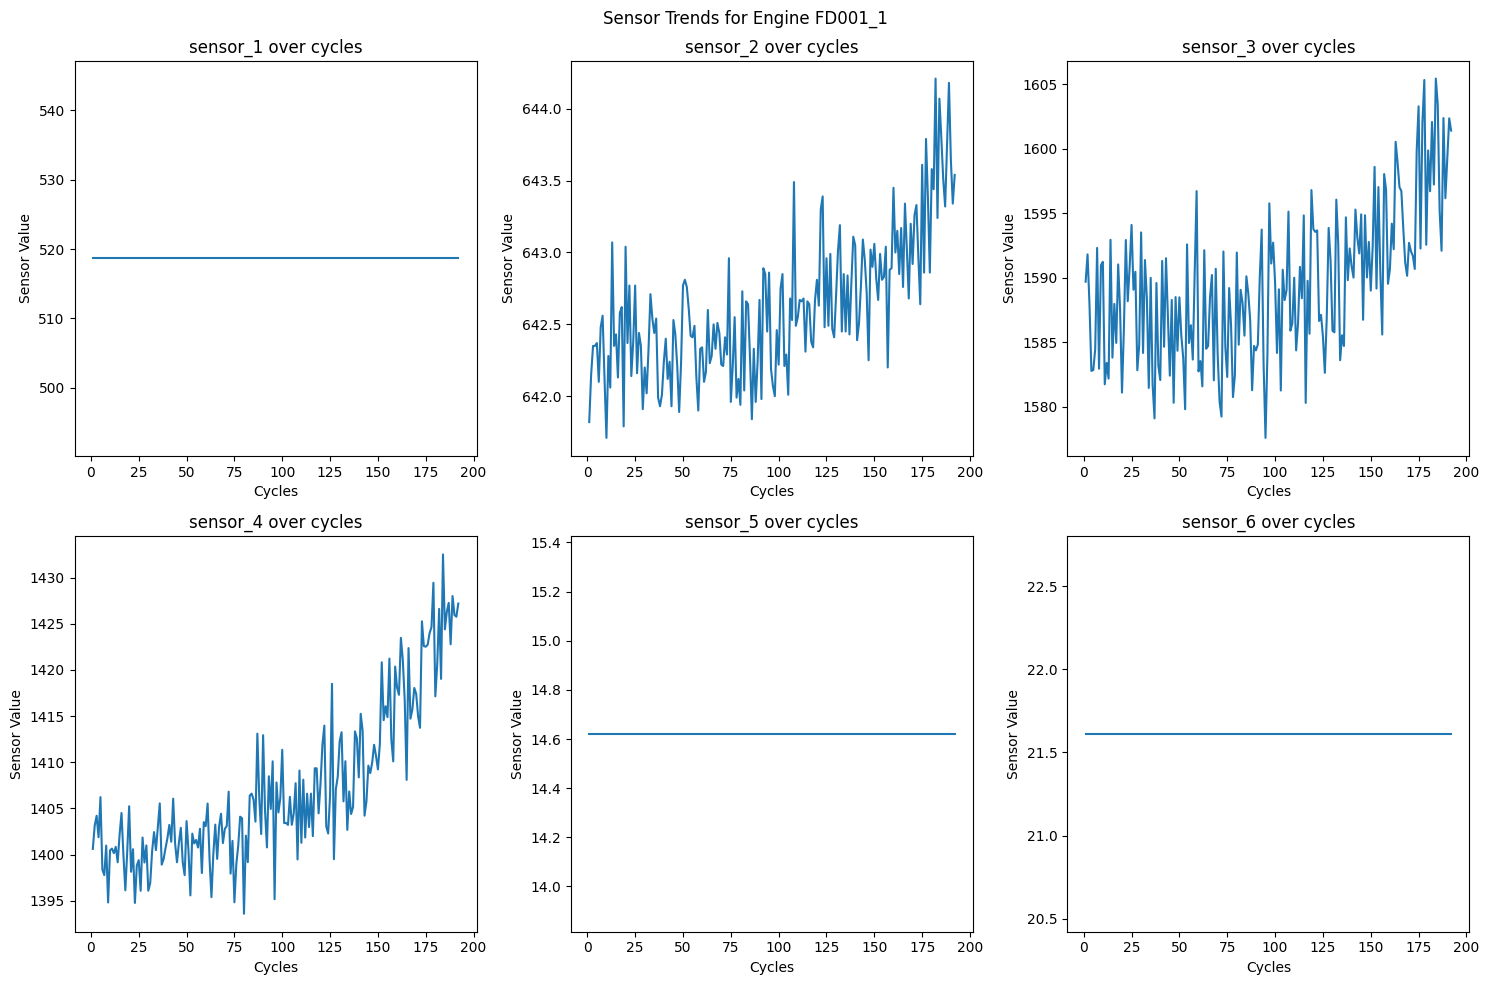

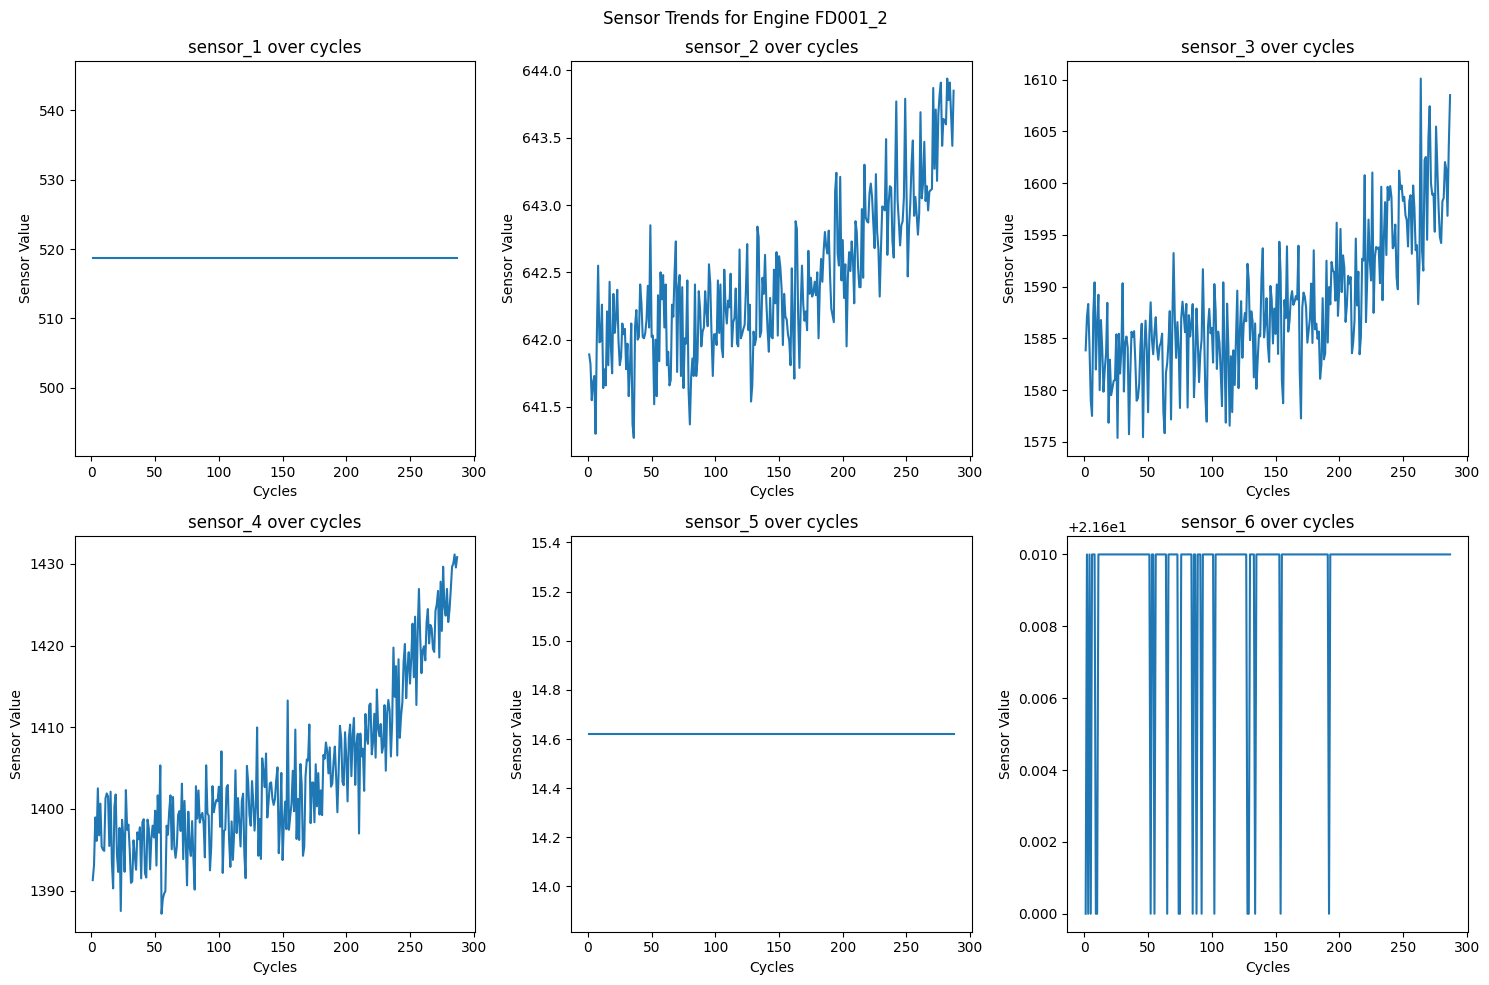

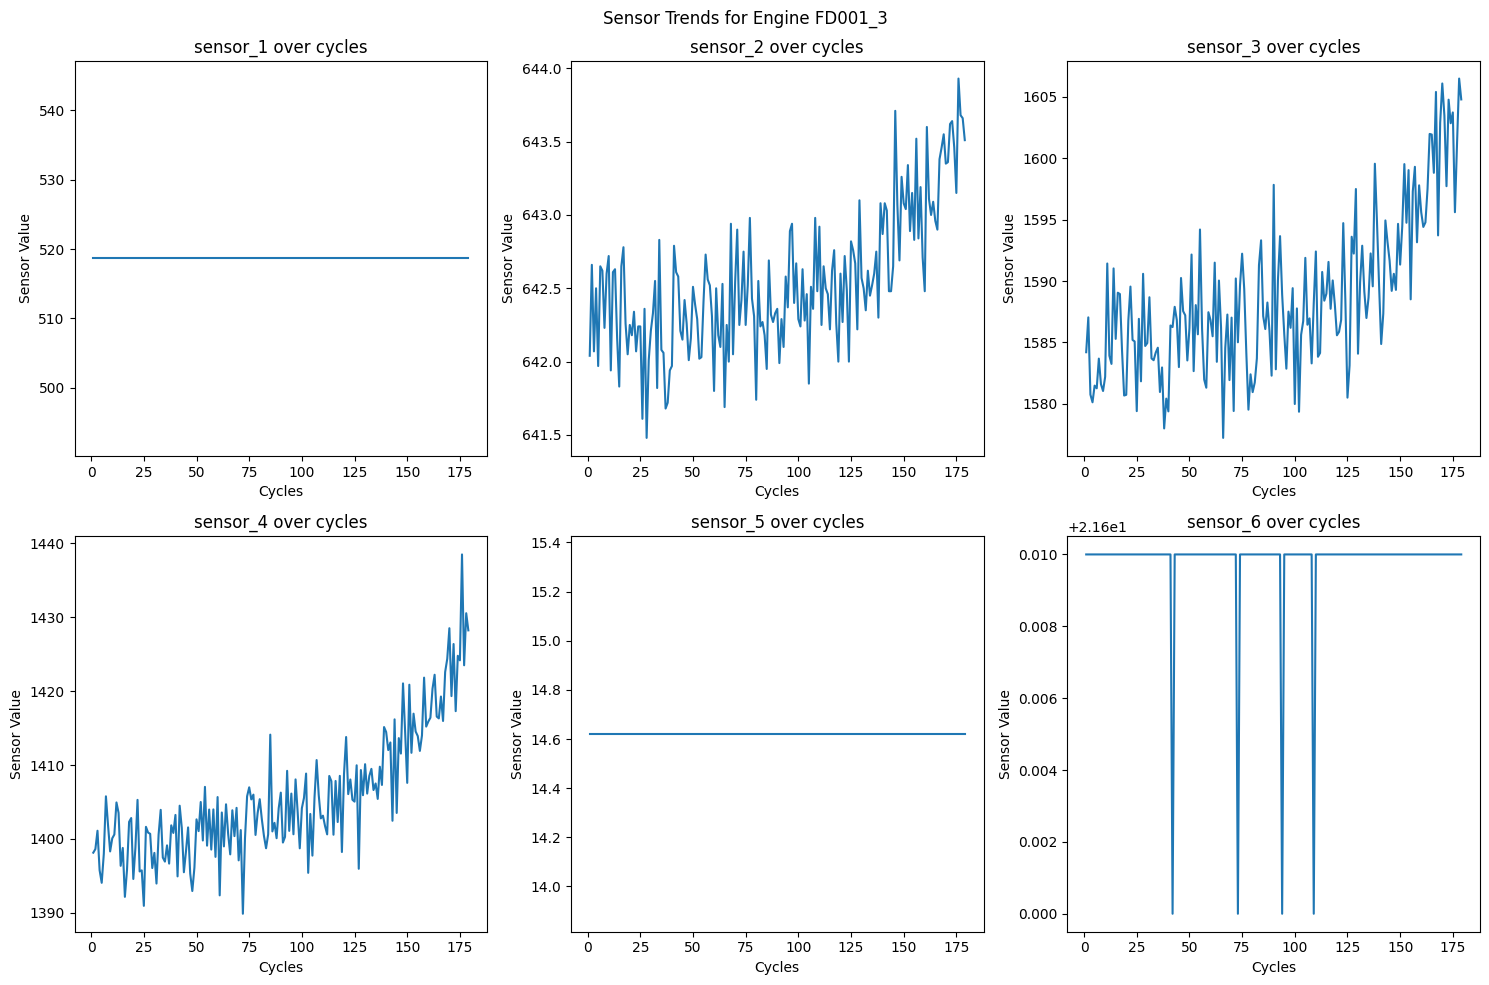

In [17]:
# Sensor trends visualization
sensor_cols = [col for col in df.columns if "sensor" in col]

# Plot sensor trends for a few engines
engine_sample = df['engine_id'].unique()[:3]
for engine in engine_sample:
    engine_data = df[df['engine_id'] == engine]
    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensor_cols[:6]): # First 6 sensors
        plt.subplot(2, 3, i+1)
        plt.plot(engine_data['cycle'], engine_data[sensor])
        plt.title(f'{sensor} over cycles')
        plt.xlabel('Cycles')
        plt.ylabel('Sensor Value')
    plt.suptitle(f'Sensor Trends for Engine {engine}')
    plt.tight_layout()
    plt.show()

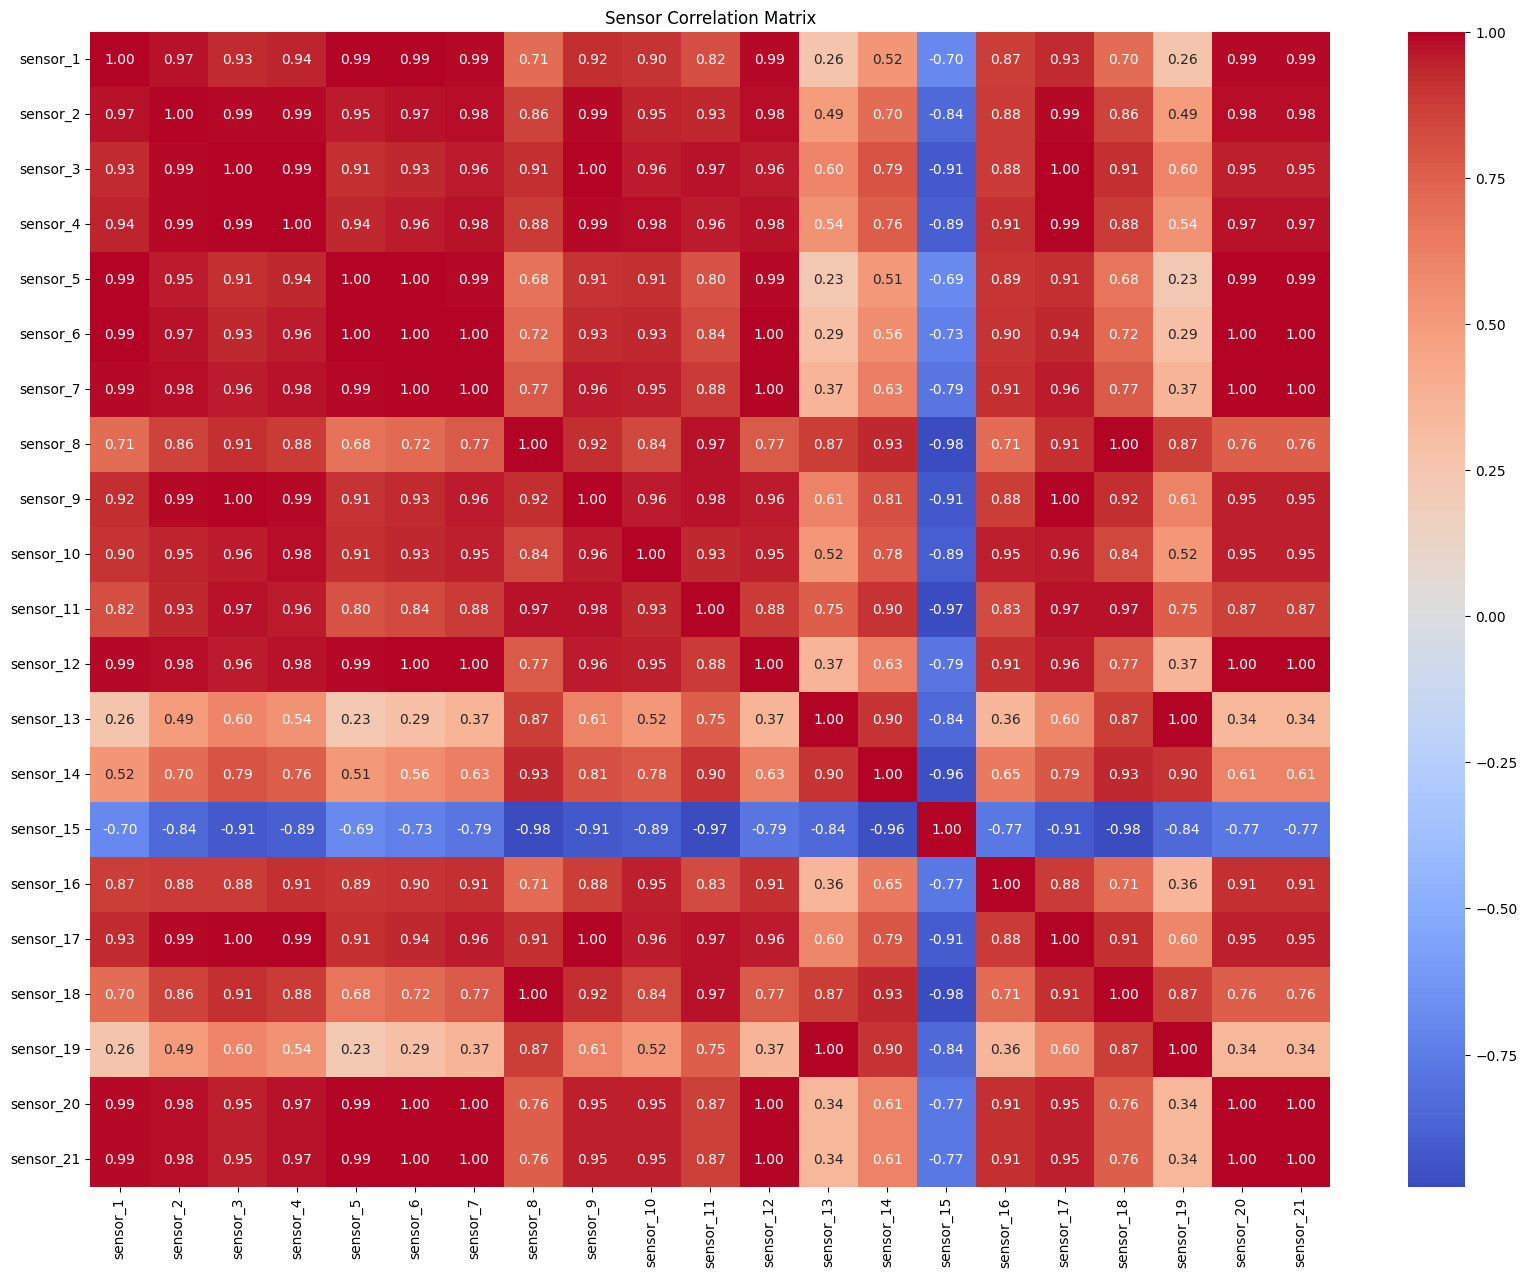

In [18]:
# Correlation Heatmap
plt.figure(figsize=(20, 15))
corr_matrix = df[sensor_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Sensor Correlation Matrix')
plt.show()

## 3. Failure Mode Analysis

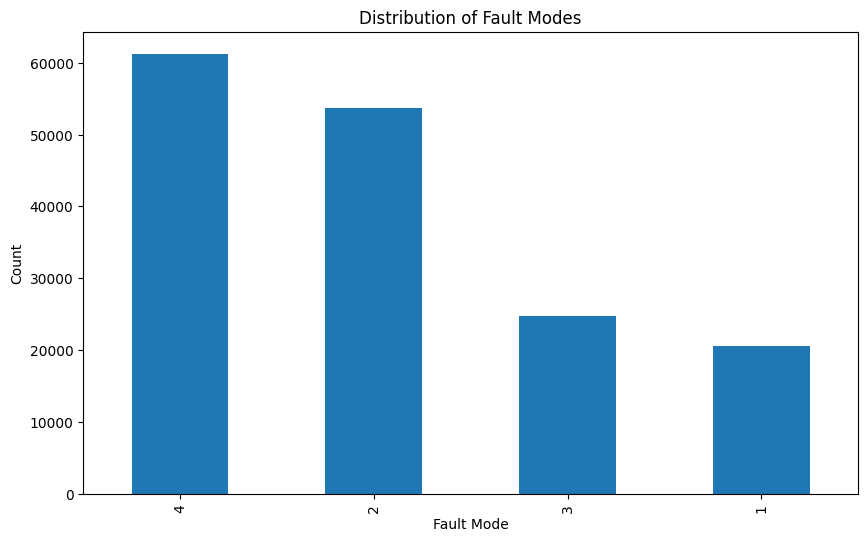

In [19]:
# Distribution of fault modes
plt.figure(figsize=(10, 6))
df['fault_mode'].value_counts().plot(kind='bar')
plt.title('Distribution of Fault Modes')
plt.xlabel('Fault Mode')
plt.ylabel('Count')
plt.show()

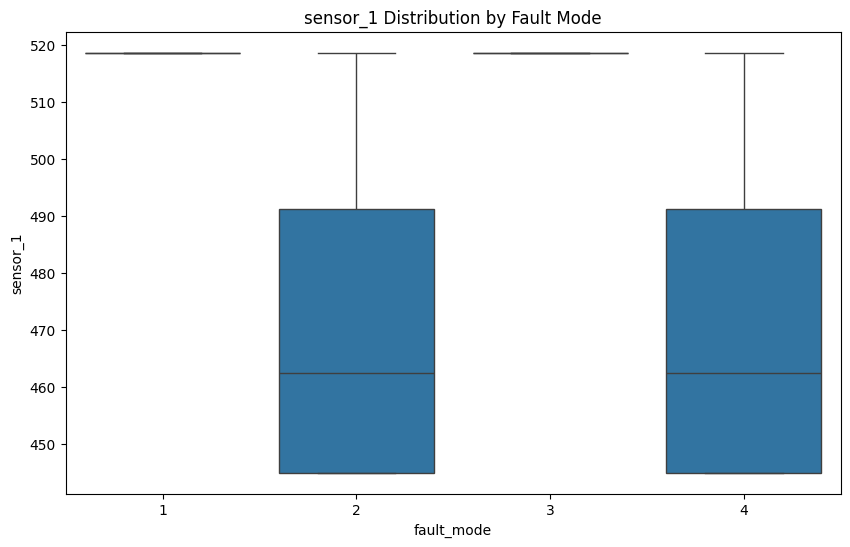

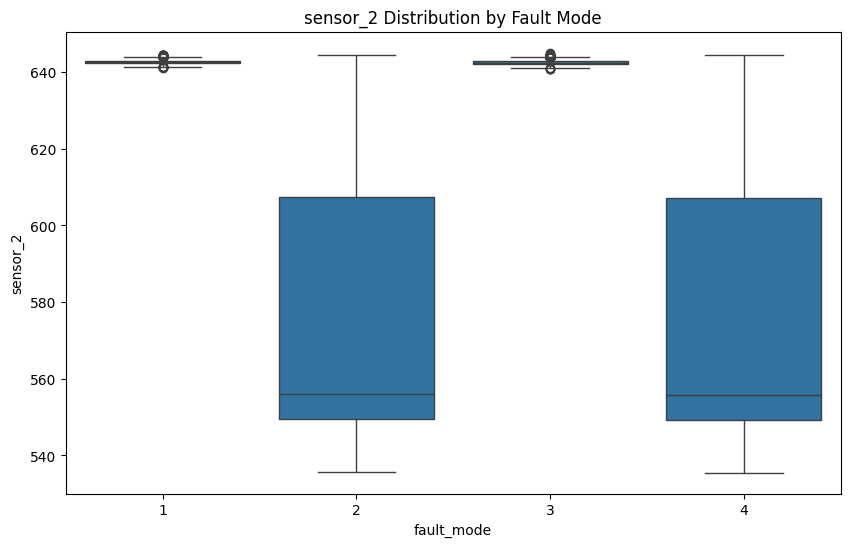

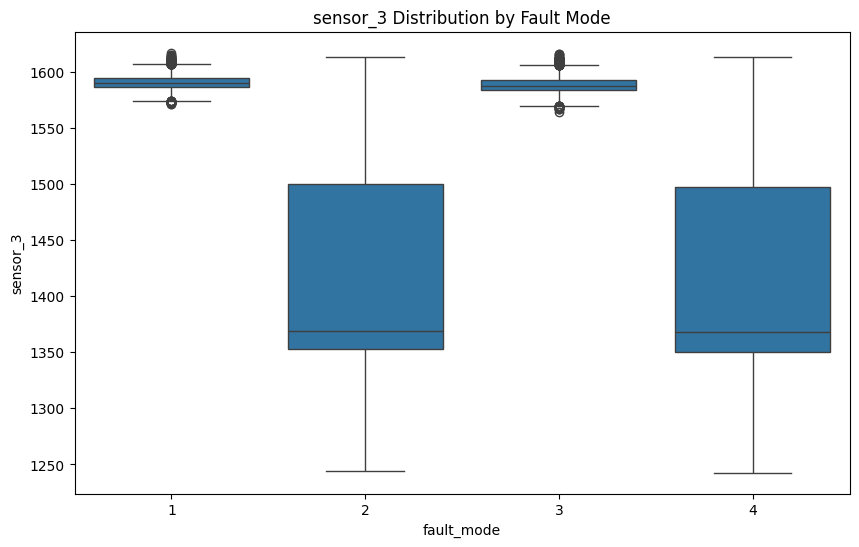

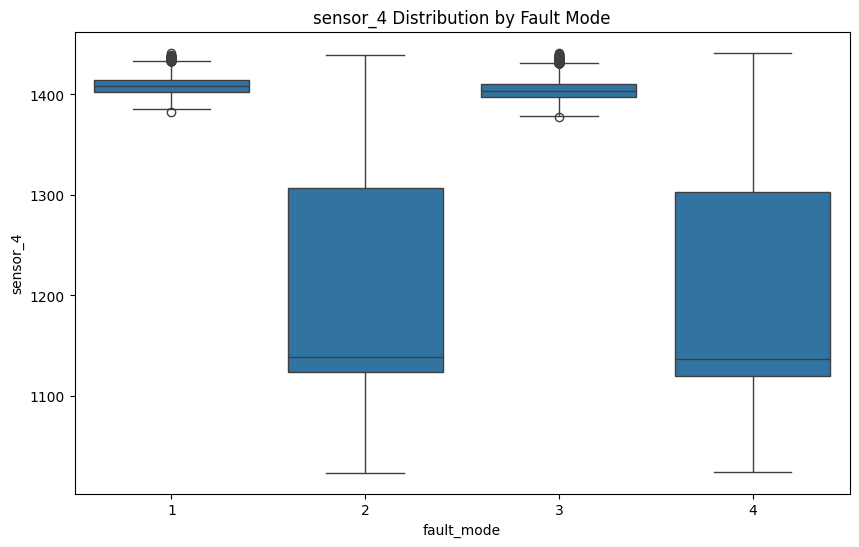

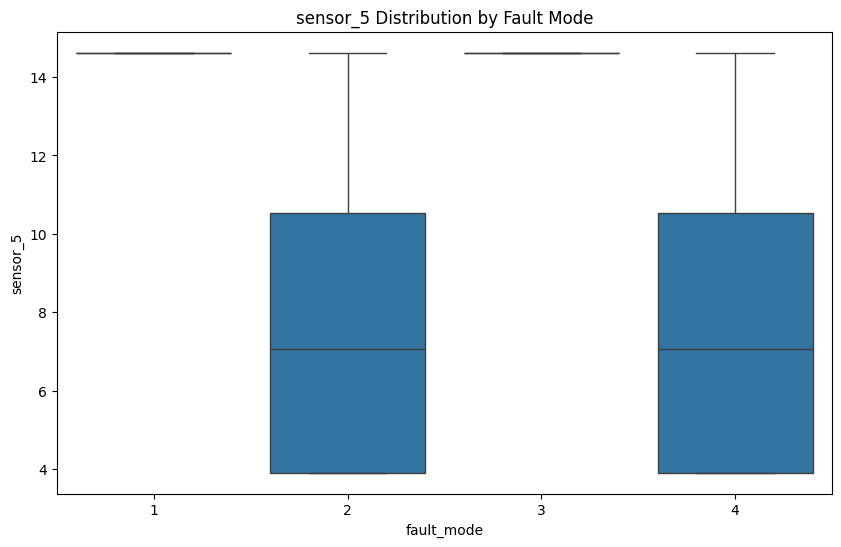

In [20]:
# Compare Sensor behaviour across fault modes
for sensor in sensor_cols[:5]: # First 5 sensors
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='fault_mode', y=sensor, data=df)
    plt.title(f'{sensor} Distribution by Fault Mode')
    plt.show()

## 4. Degradation Analysis

In [21]:
df = add_rul(df)

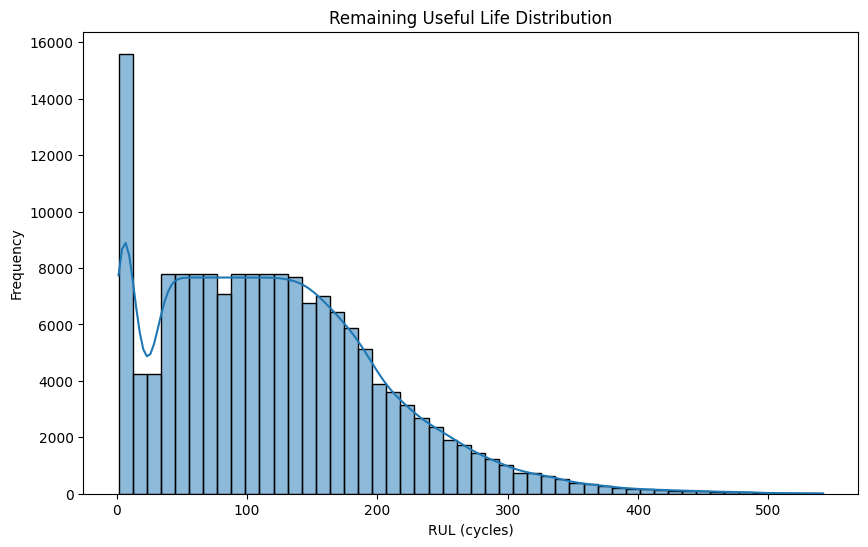

In [22]:
# Plot RUL Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['RUL'], bins=50, kde=True)
plt.title('Remaining Useful Life Distribution')
plt.xlabel('RUL (cycles)')
plt.ylabel('Frequency')
plt.show()

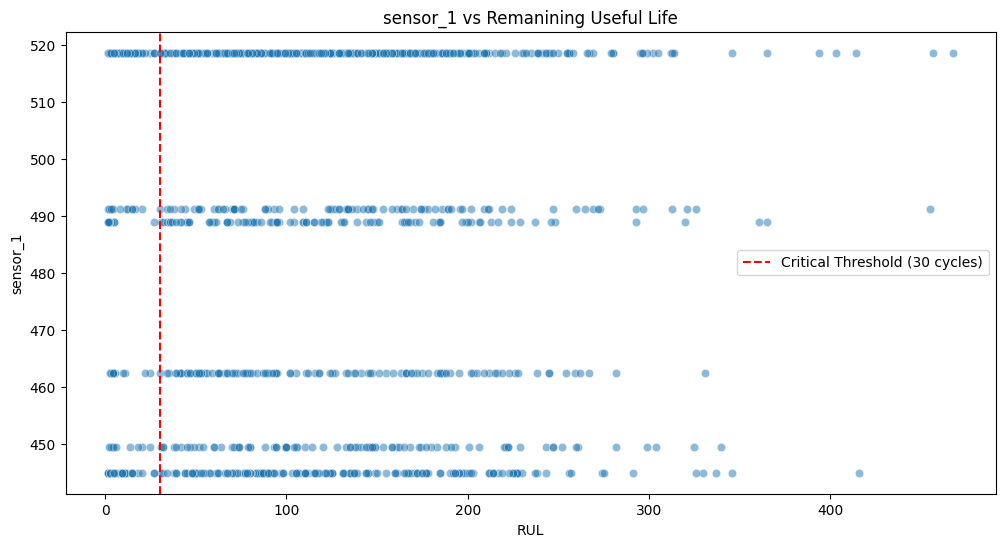

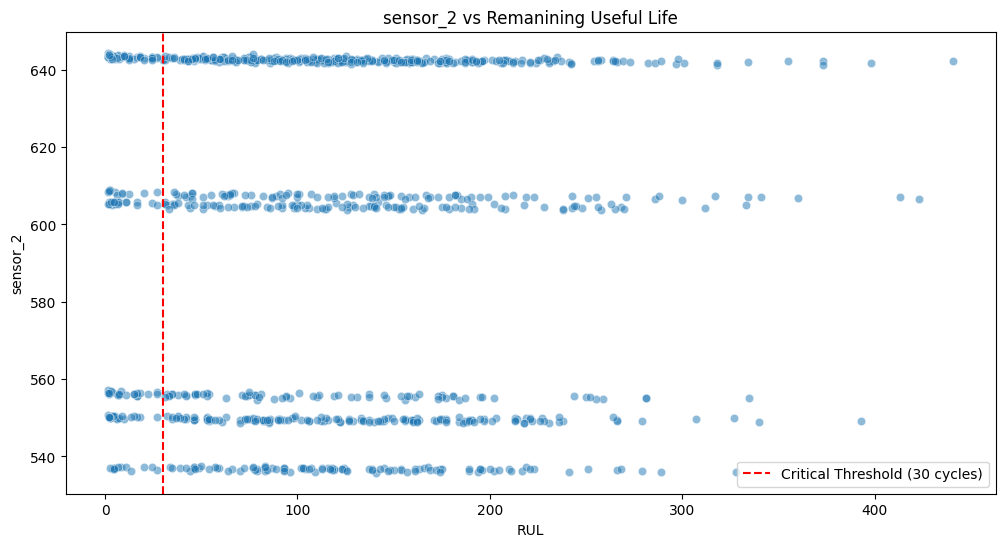

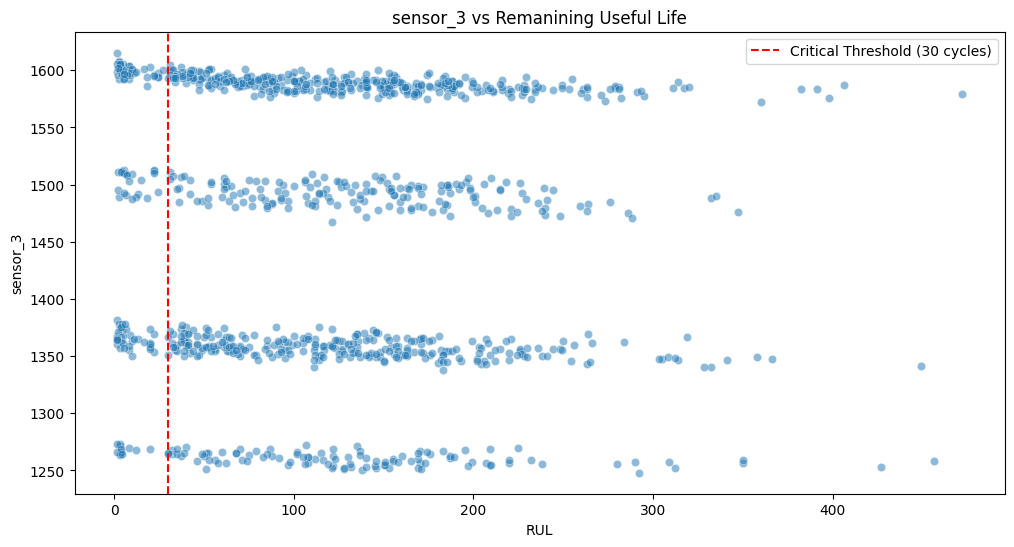

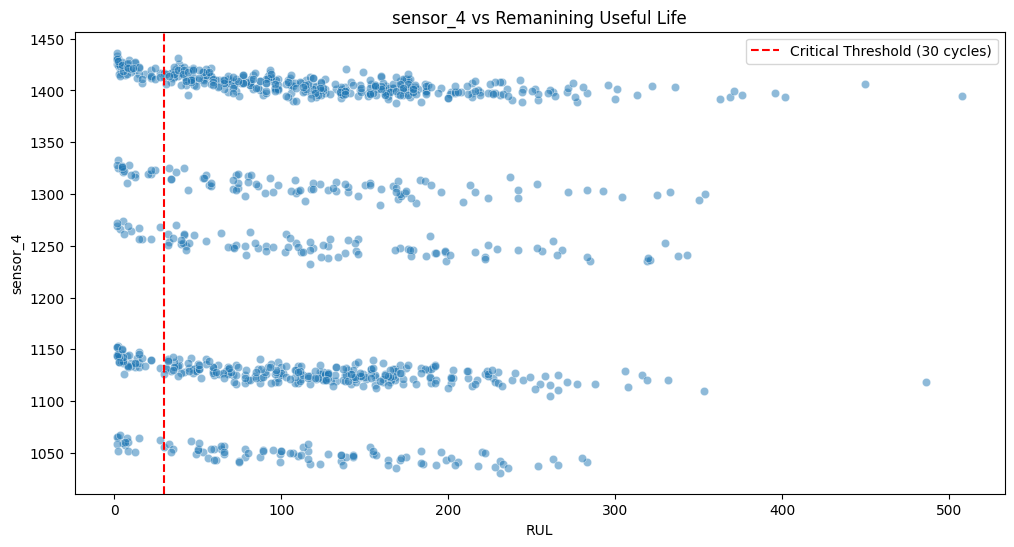

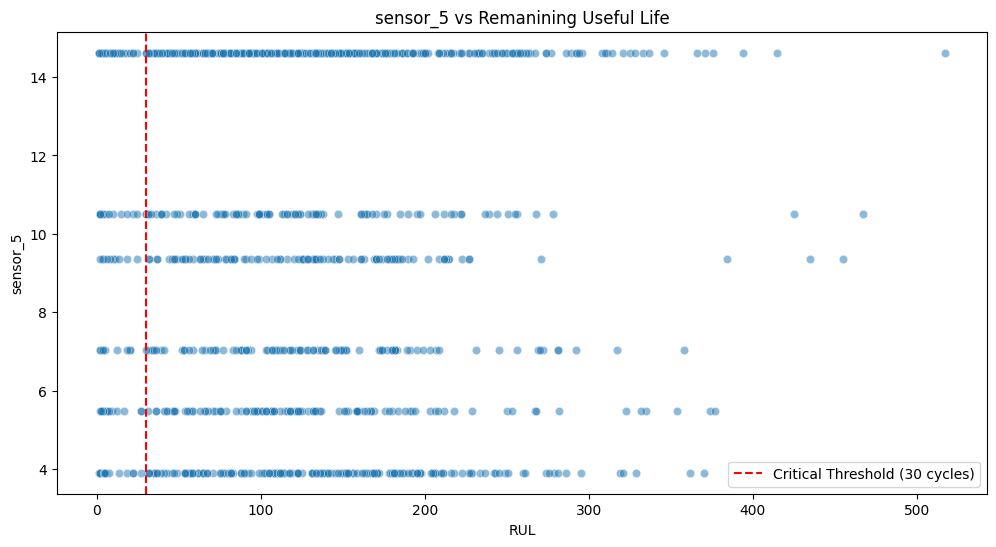

In [23]:
# Sensor behaviour vs RUL
for sensor in sensor_cols[:5]: # First 5 sensors
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='RUL', y=sensor, data=df.sample(1000), alpha=0.5)
    plt.title(f'{sensor} vs Remanining Useful Life')
    plt.axvline(x=30, color='r', linestyle='--', label='Critical Threshold (30 cycles)')
    plt.legend()
    plt.show()

## 5. Operating Condition Analysis

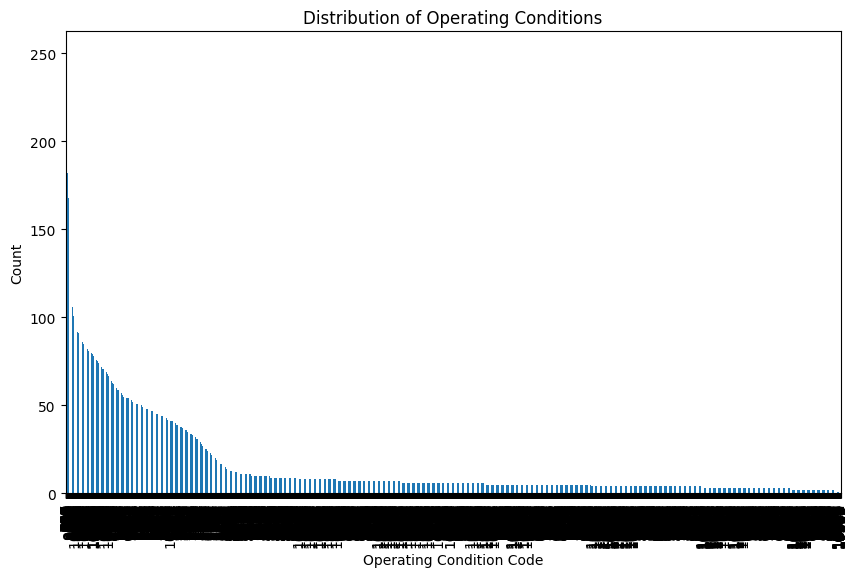

In [25]:
# Distribution across operating conditions
plt.figure(figsize=(10, 6))
df['operating_condition'].value_counts().plot(kind='bar')
plt.title('Distribution of Operating Conditions')
plt.xlabel('Operating Condition Code')
plt.ylabel('Count')
plt.show()

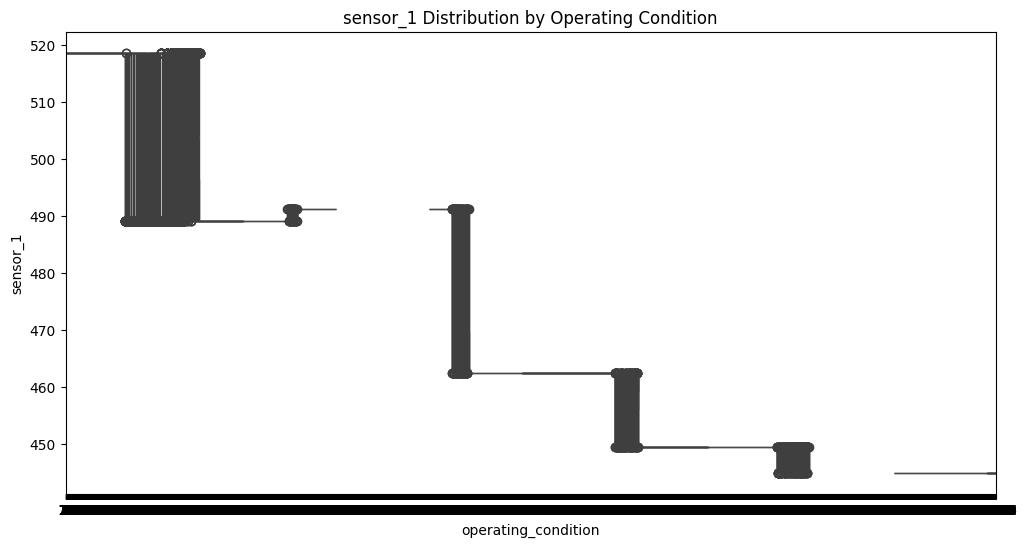

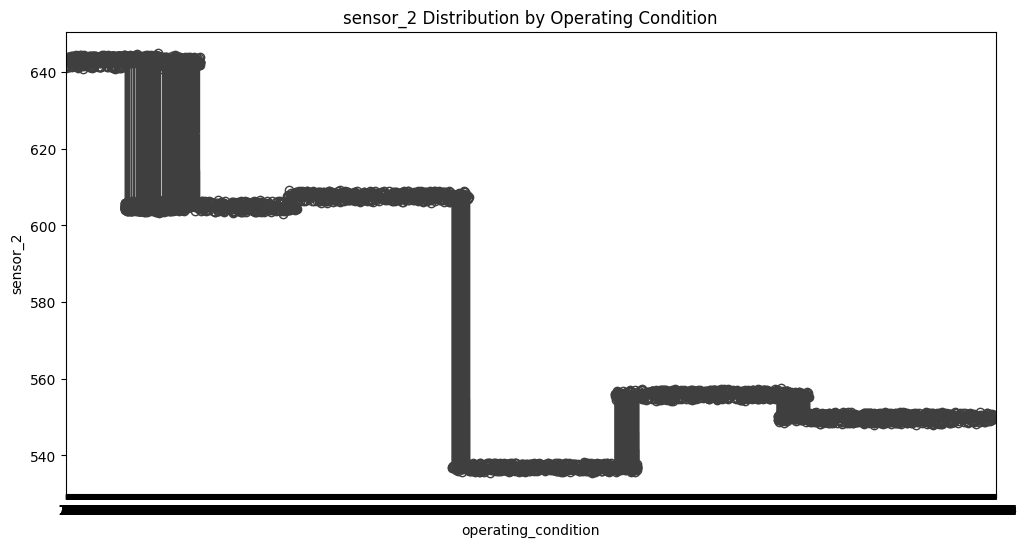

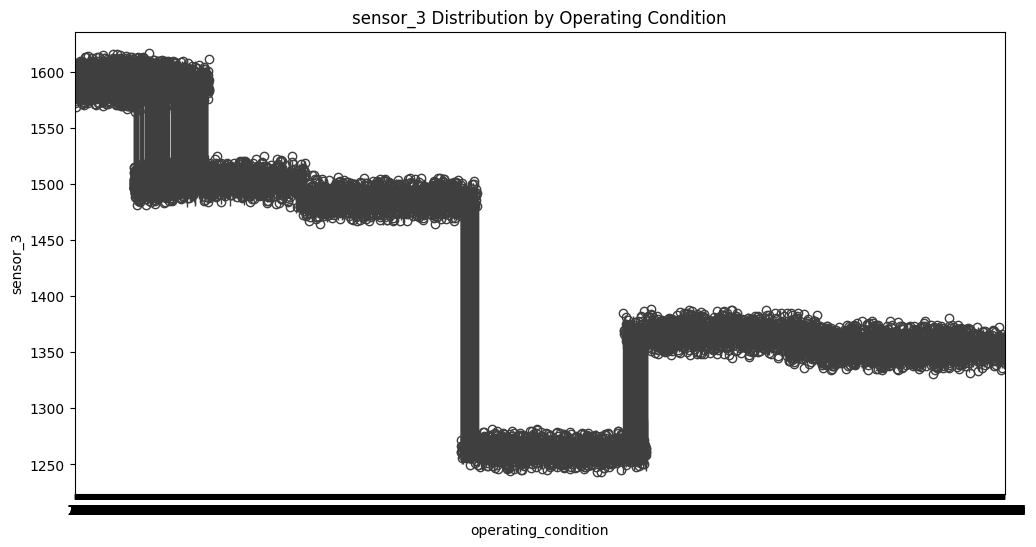

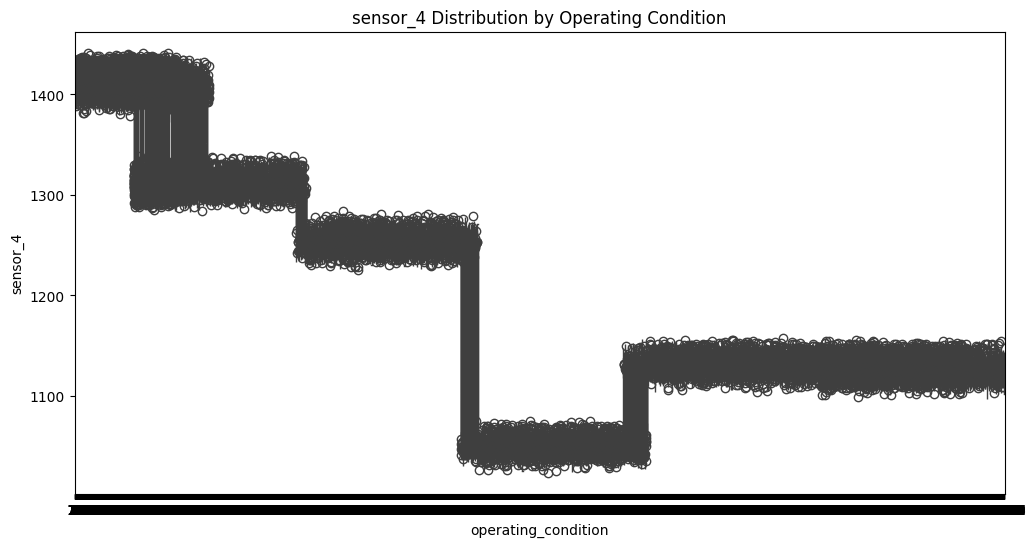

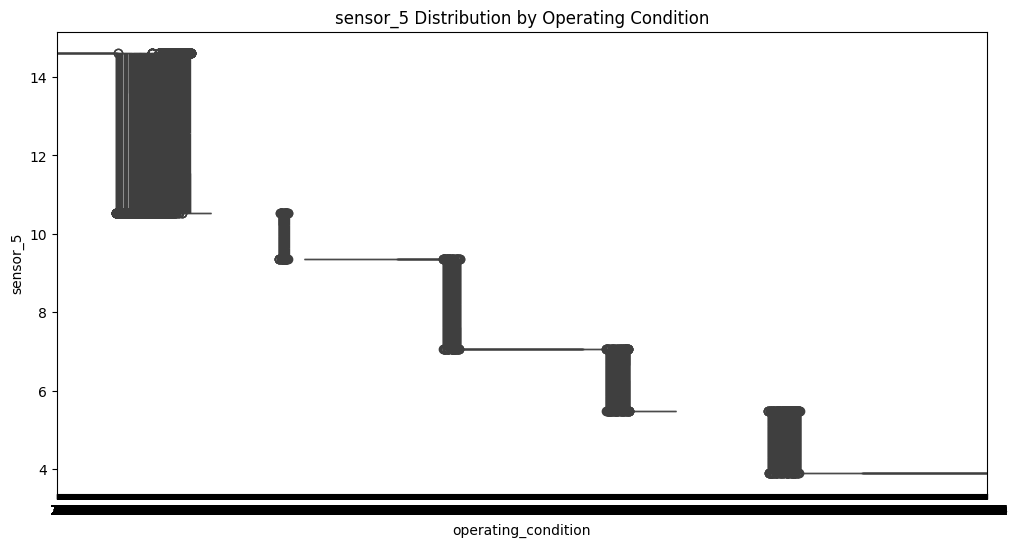

In [28]:
# Compare sensor behaviour across operating conditions
for sensor in sensor_cols[:5]: # First 5 sensors
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='operating_condition', y=sensor, data=df)
    plt.title(f'{sensor} Distribution by Operating Condition')
    plt.show()

## 6. Feature Importance Analysis

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [30]:
# Prepare data for feature importance
X = df[sensor_cols + ['operating_condition', 'fault_mode']]
y = df['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Train a simple model for feature importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
# Plot feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

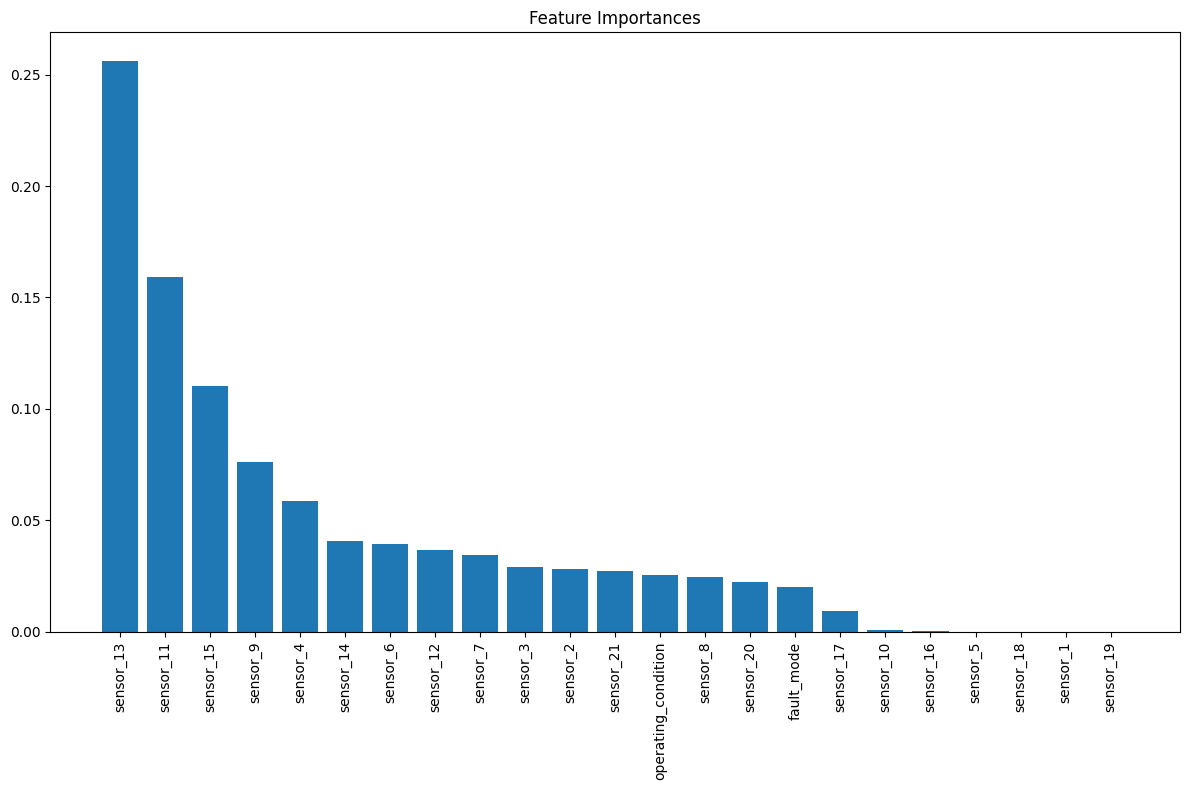

In [33]:
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

## 7. Time-series Pattern Analysis

In [34]:
# Plot sensor trends leading to failure
failing_engines = df.groupby('engine_id')['RUL'].min()
sample_failing = failing_engines[failing_engines < 10].index[:3] #engines that failed

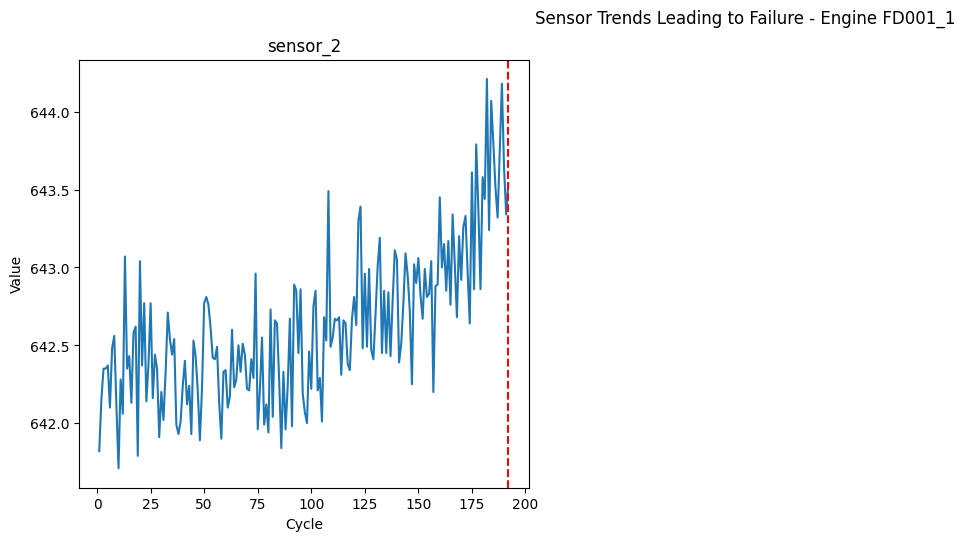

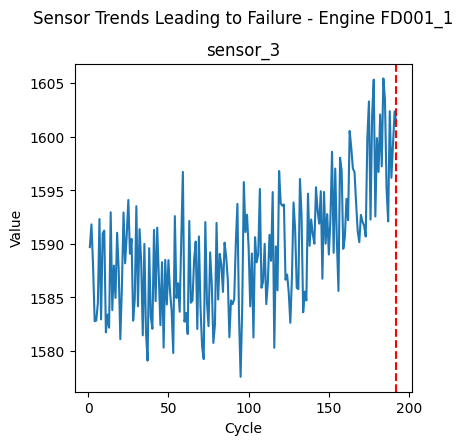

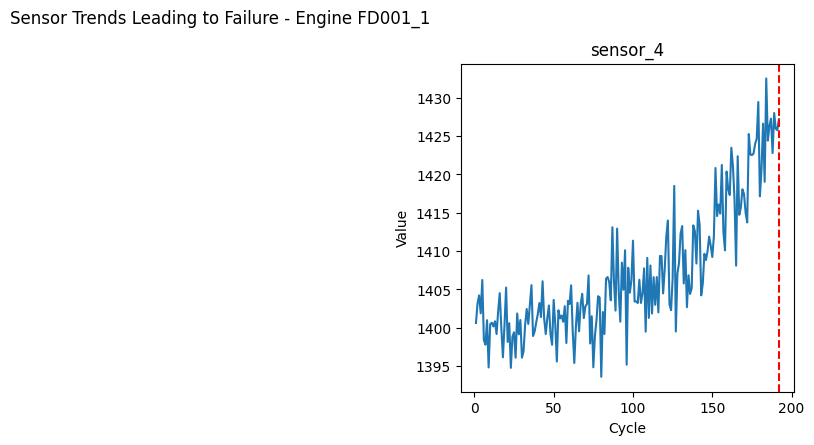

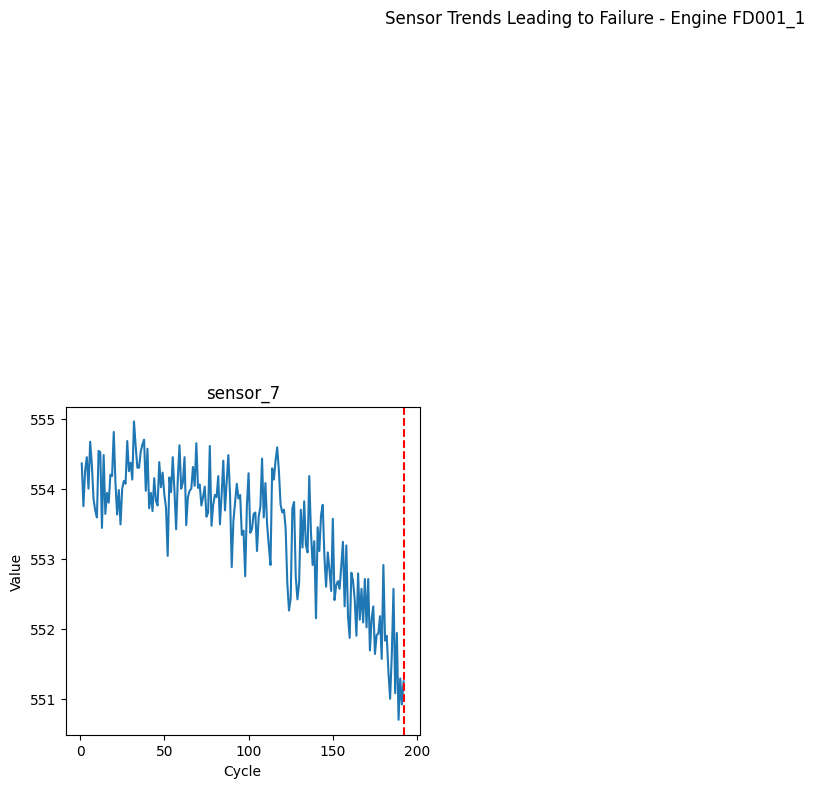

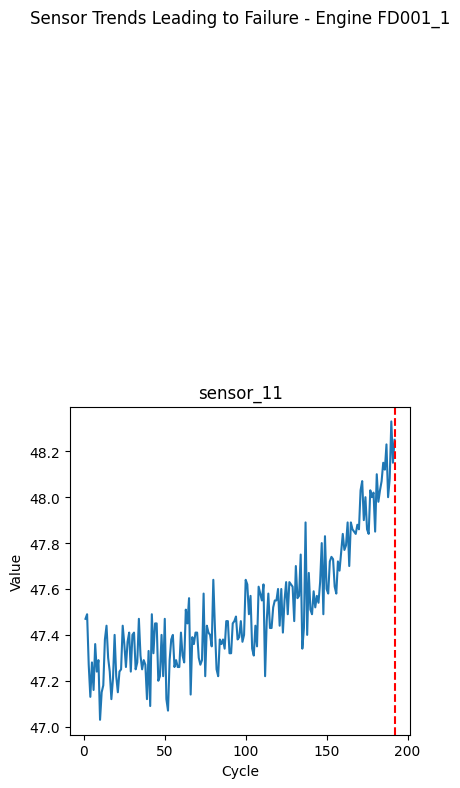

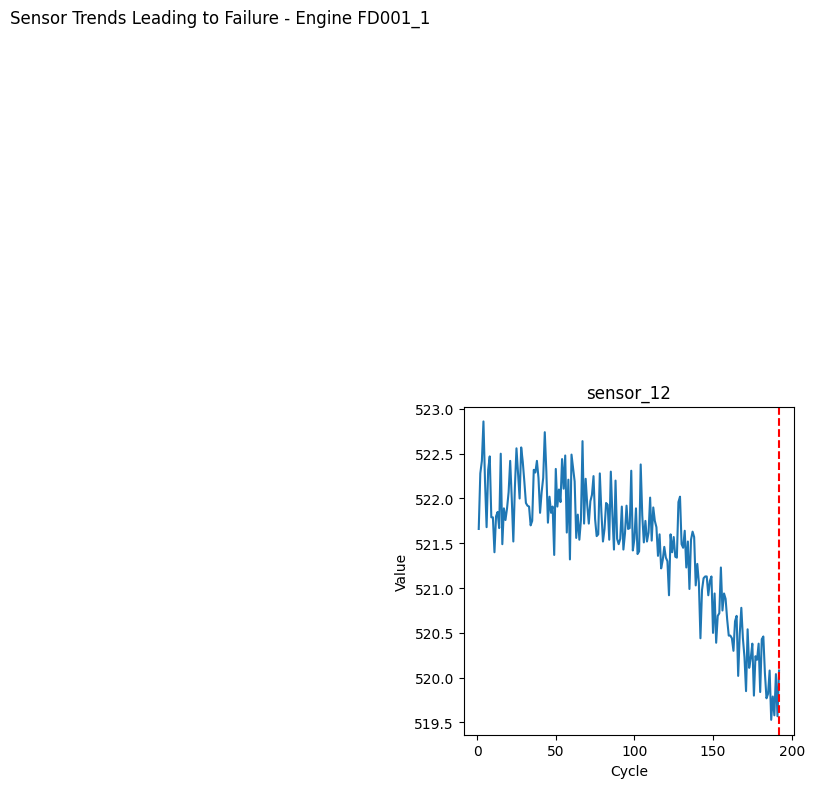

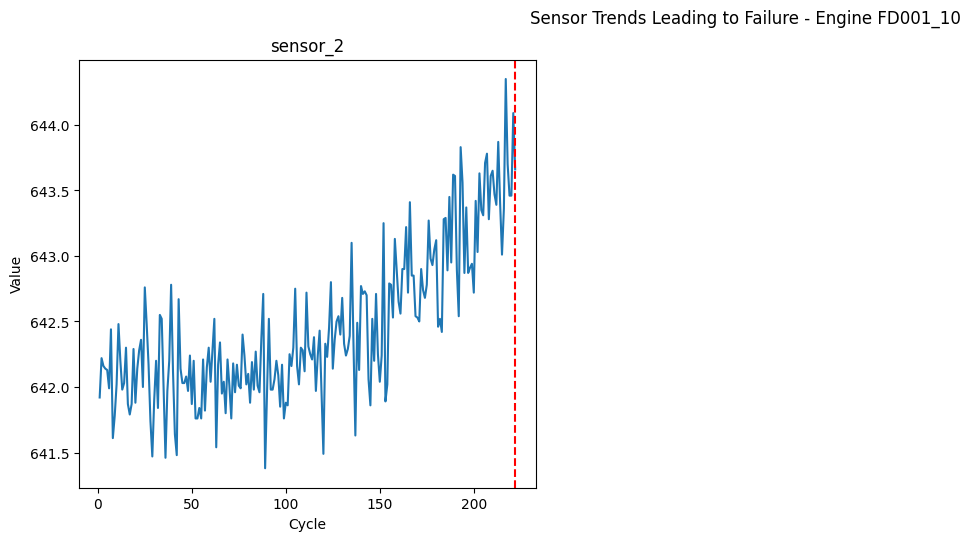

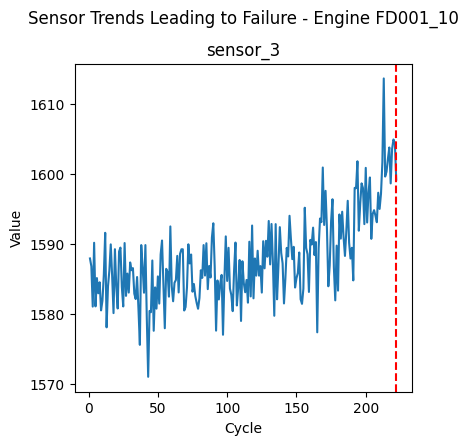

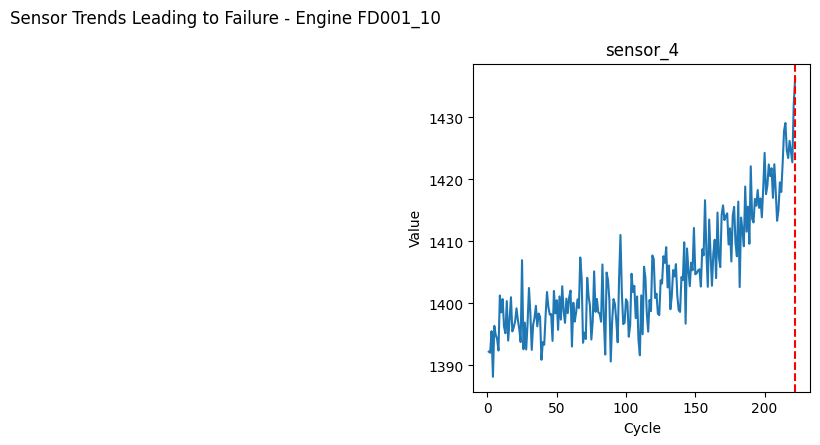

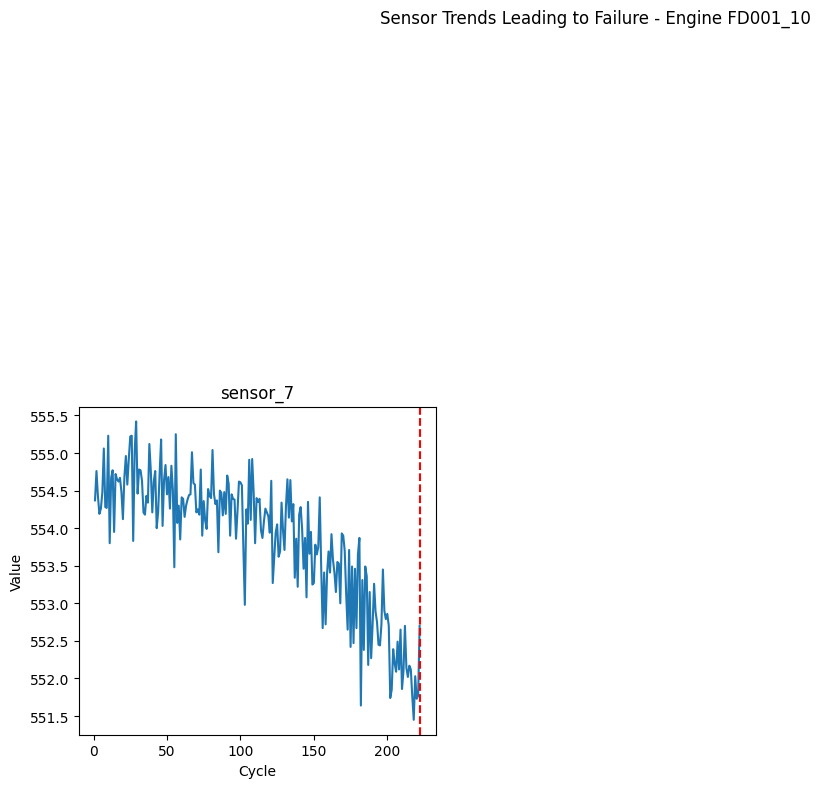

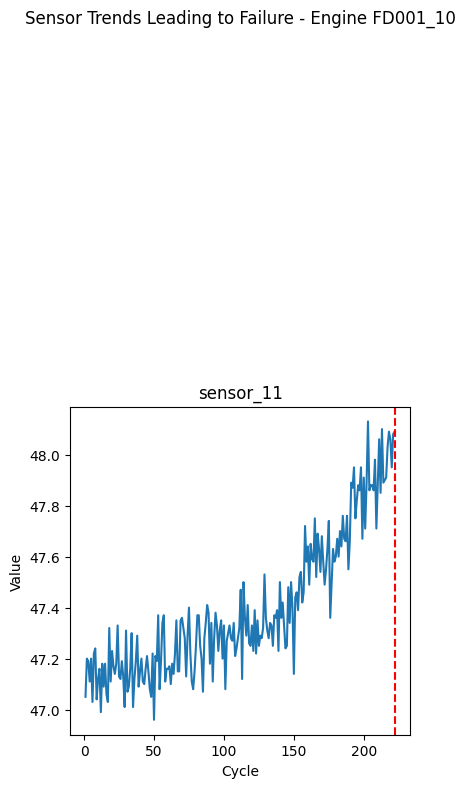

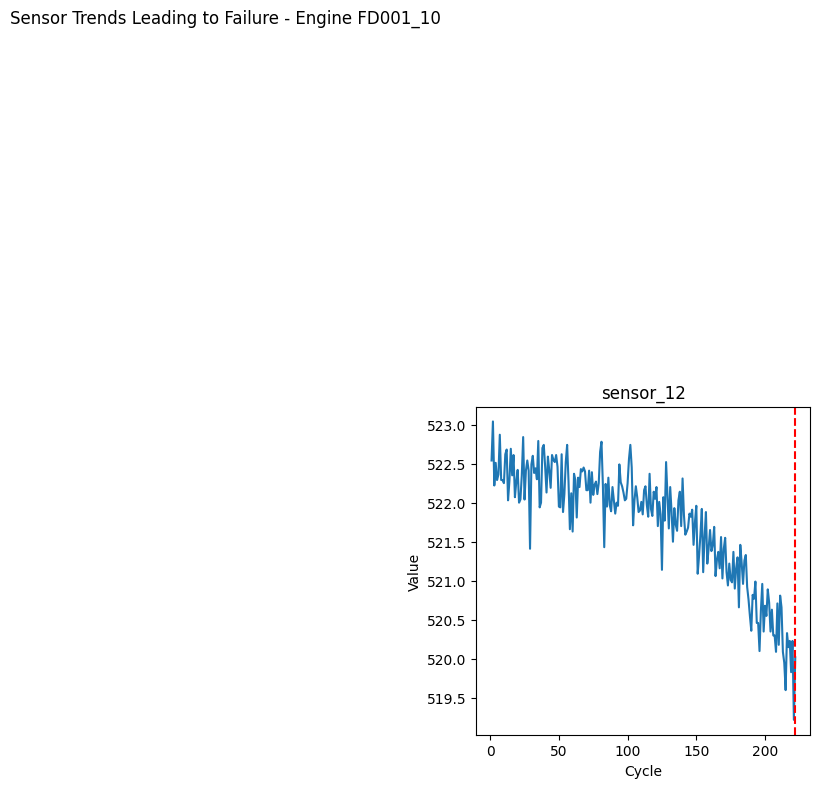

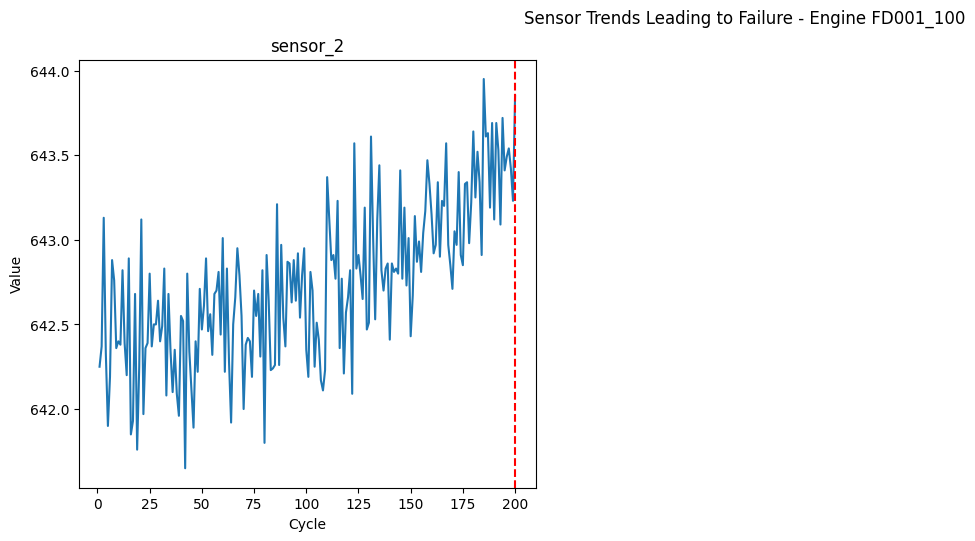

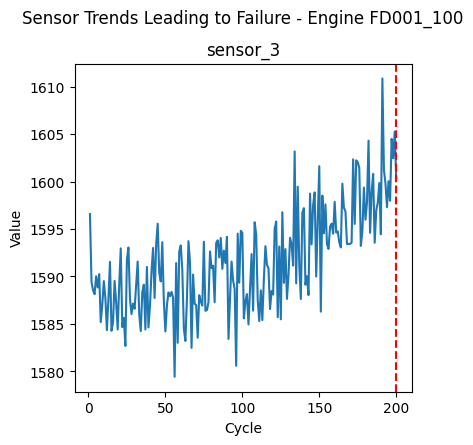

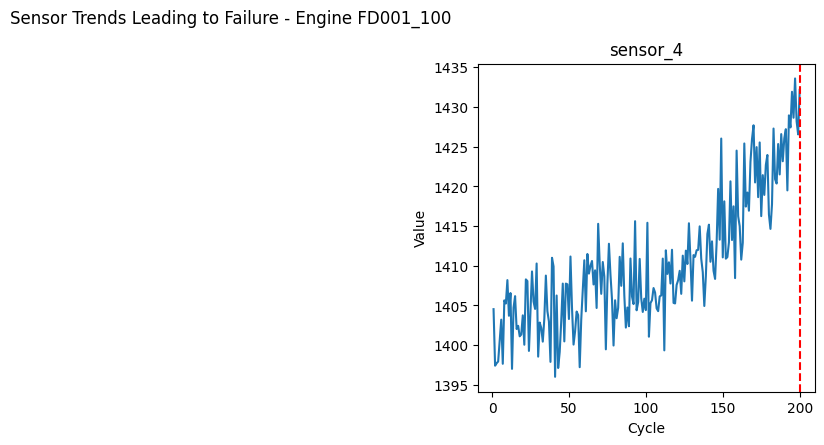

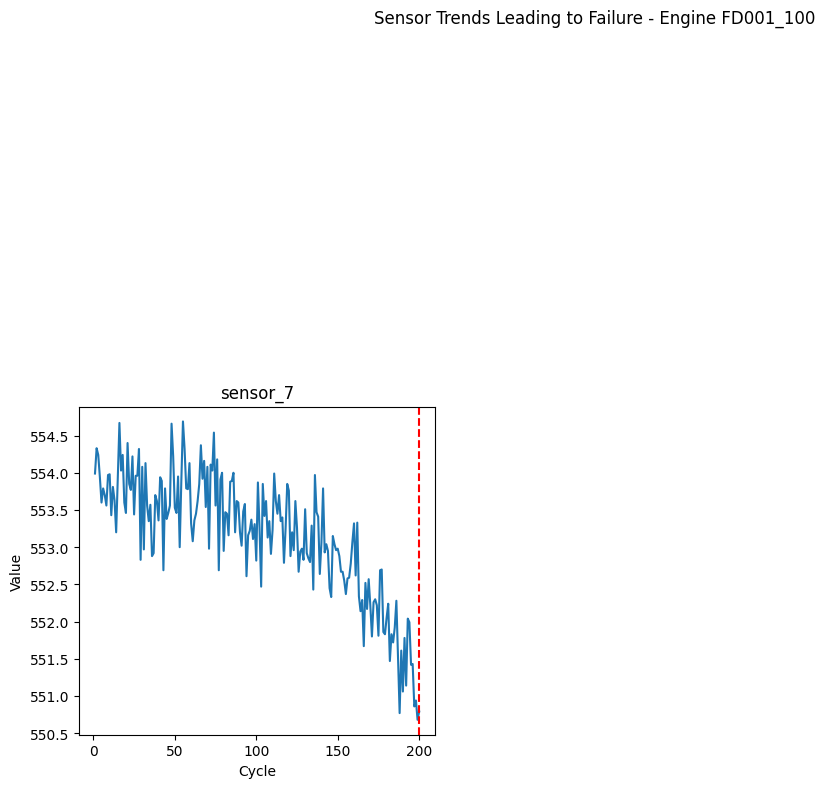

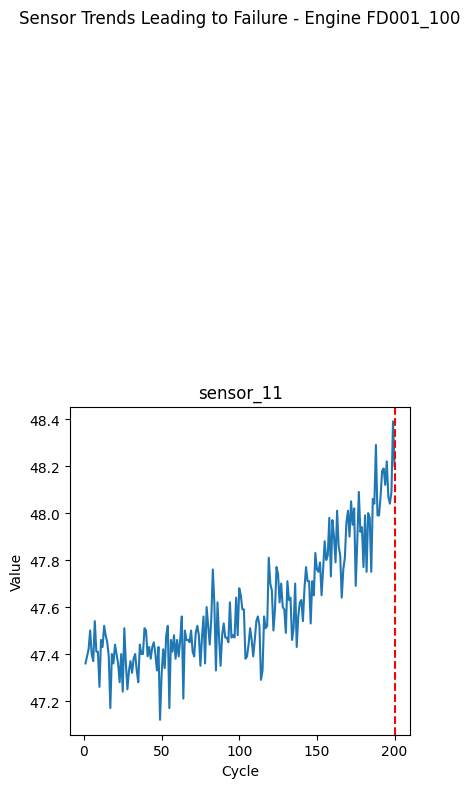

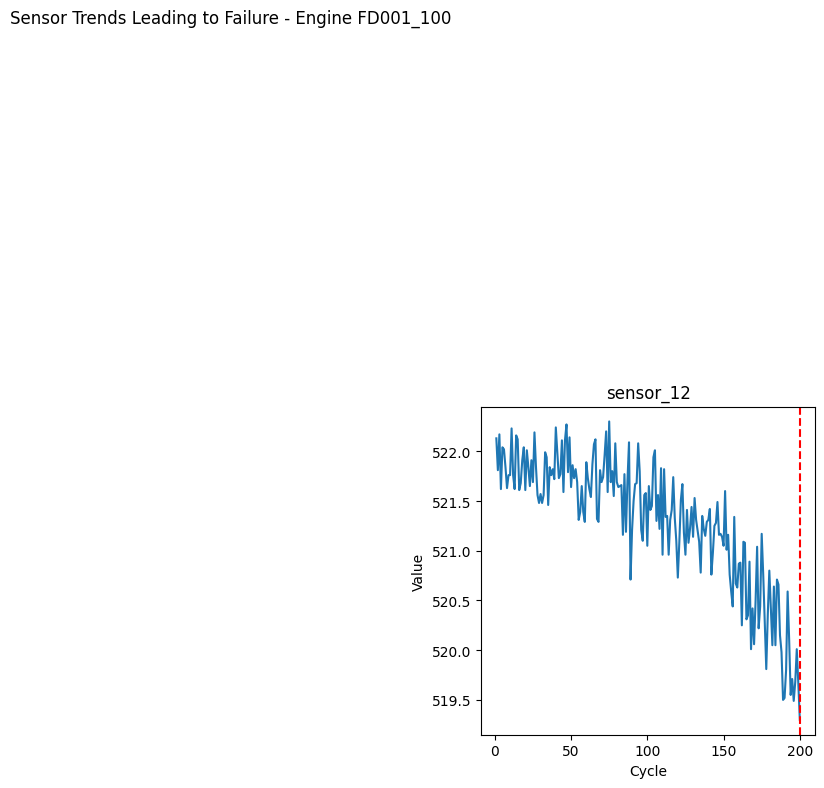

In [35]:
for engine in sample_failing:
    engine_data = df[df['engine_id'] == engine]
    plt.figure(figsize=(15, 10))

    # Plot key sensors
    importance_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', ]
    for i, sensor in enumerate(importance_sensors):
        plt.subplot(2, 3, i+1)
        plt.plot(engine_data['cycle'], engine_data[sensor])
        plt.title(f'{sensor}')
        plt.xlabel('Cycle')
        plt.ylabel('Value')

        # Mark the failure point
        failure_cycle = engine_data['cycle'].max()
        plt.axvline(x=failure_cycle, color='r', linestyle='--')

        plt.suptitle(f'Sensor Trends Leading to Failure - Engine {engine}')
        plt.tight_layout()
        plt.show()

## 8. Advanced Visualizations

*Interactive 3D plot of sensor relationships*

In [41]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

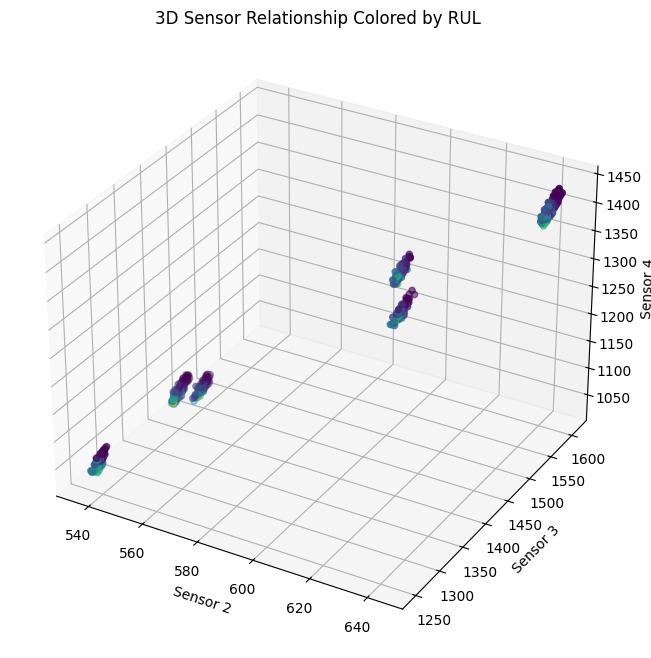

In [42]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sample = df.sample(1000)
ax.scatter(sample['sensor_2'], sample['sensor_3'], sample['sensor_4'], c=sample['RUL'], cmap='viridis')
ax.set_xlabel('Sensor 2')
ax.set_ylabel('Sensor 3')
ax.set_zlabel('Sensor 4')
plt.title('3D Sensor Relationship Colored by RUL')
plt.show()

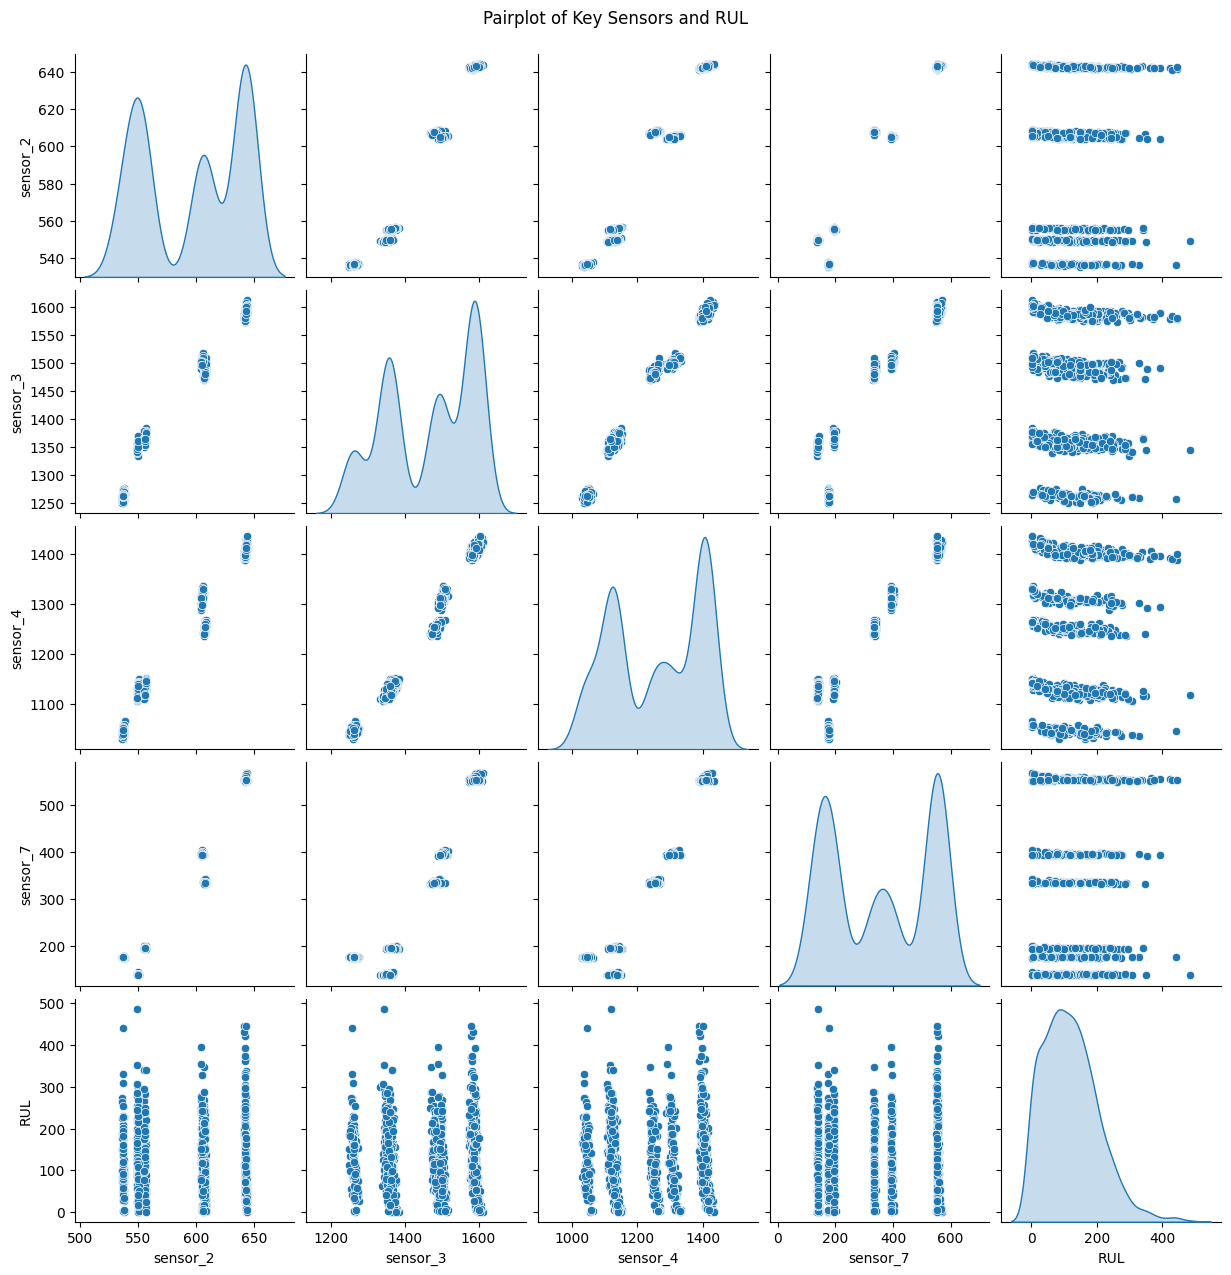

In [43]:
# Pairplot of key sensors
key_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'RUL']
sns.pairplot(df.sample(1000)[key_sensors], diag_kind='kde')
plt.suptitle("Pairplot of Key Sensors and RUL", y=1.02)
plt.show()

## 9. Statistical Tests

In [45]:
from scipy.stats import ttest_ind

In [47]:
# Compare sensor values between early and late life cycles
df['life_stage'] = np.where(df['RUL'] > df['RUL'].median(), 'Early', 'Late')

for sensor in sensor_cols[:5]:
    early = df[df['life_stage'] == 'Early'][sensor]
    late = df[df['life_stage'] == 'Late'][sensor]

    t_stat, p_val = ttest_ind(early, late, equal_var=False)
    print(f'{sensor}: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}')

    if p_val < 0.05:
        print(f'\nSignificant difference in {sensor} between early and late life changes\n')

sensor_1: t-statistic = -0.20, p-value = 0.8394
sensor_2: t-statistic = -2.18, p-value = 0.0292

Significant difference in sensor_2 between early and late life changes

sensor_3: t-statistic = -10.54, p-value = 0.0000

Significant difference in sensor_3 between early and late life changes

sensor_4: t-statistic = -14.71, p-value = 0.0000

Significant difference in sensor_4 between early and late life changes

sensor_5: t-statistic = -0.36, p-value = 0.7199


## 10. Degradation Signatures

*Calculate rolling statistics for key sensors*

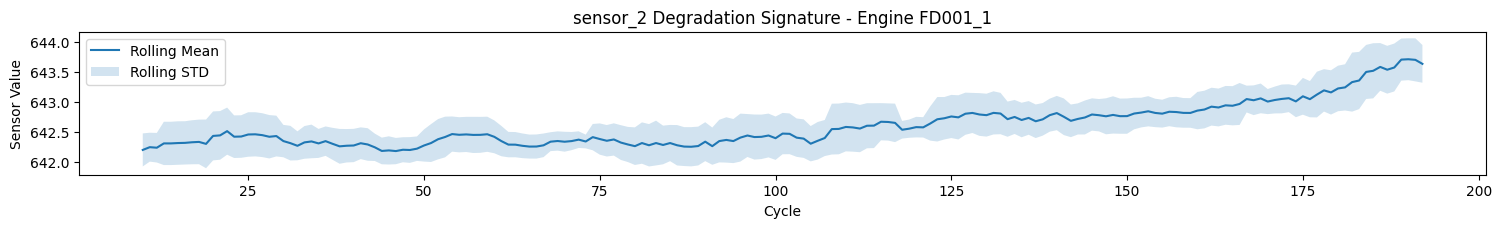

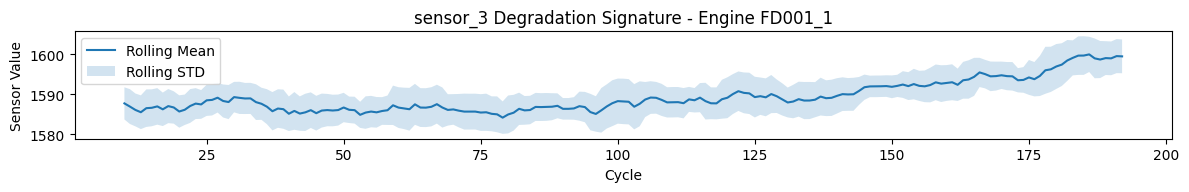

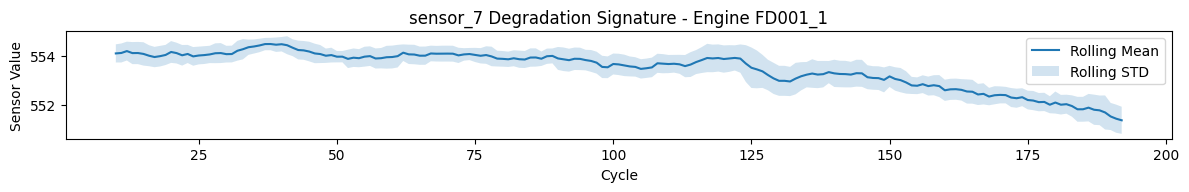

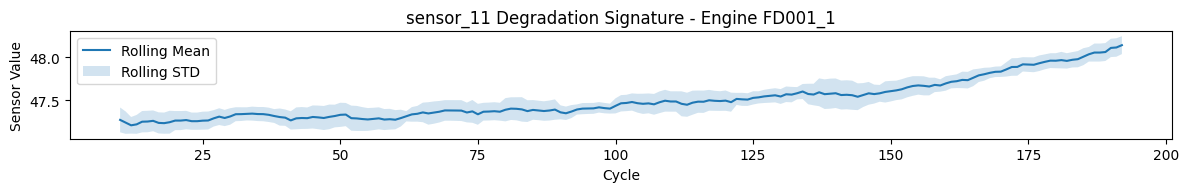

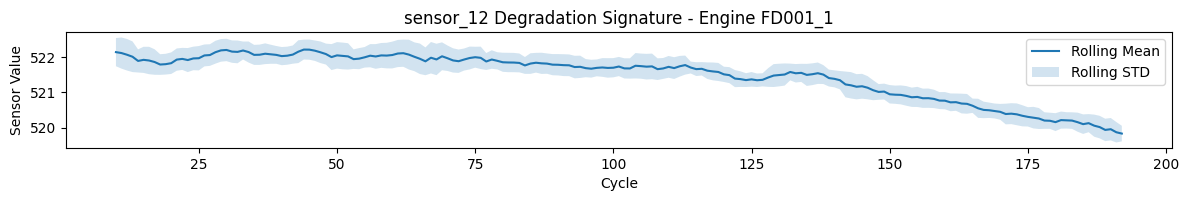

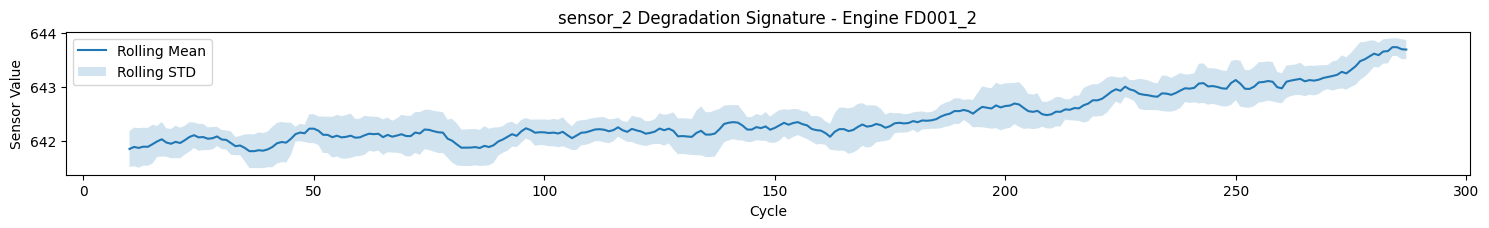

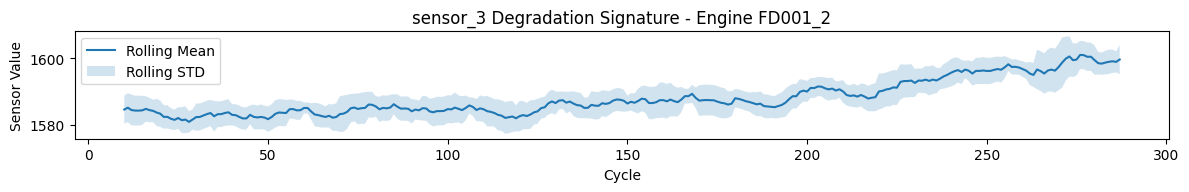

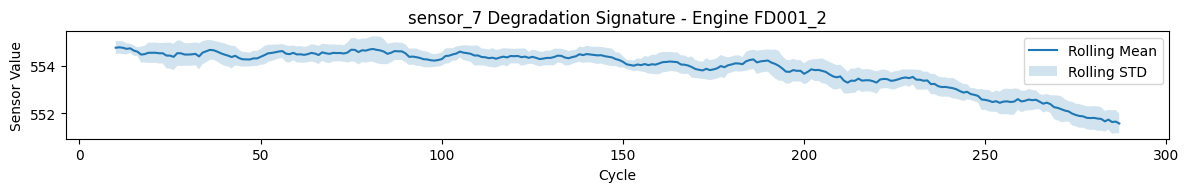

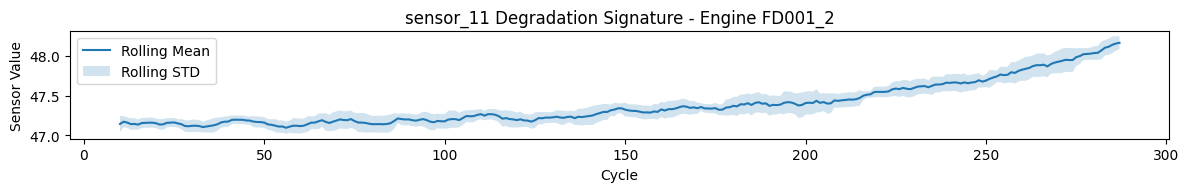

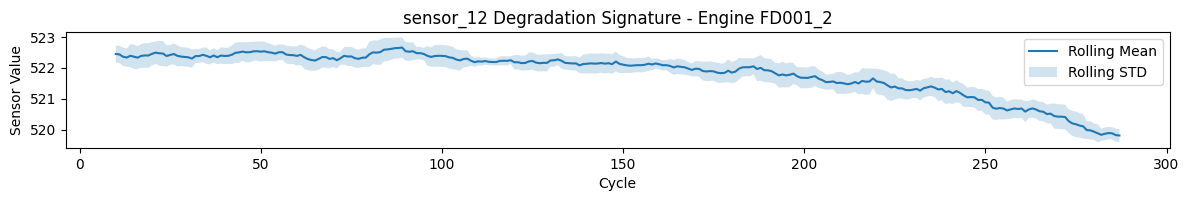

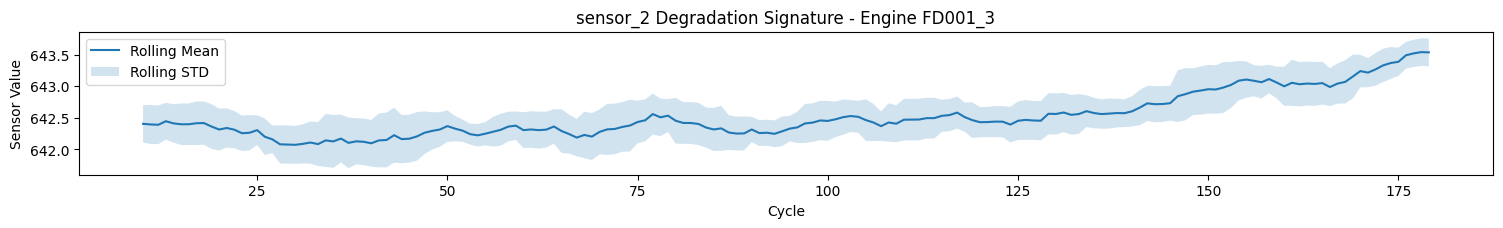

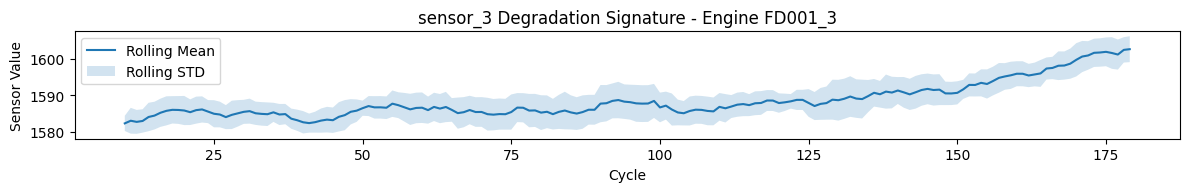

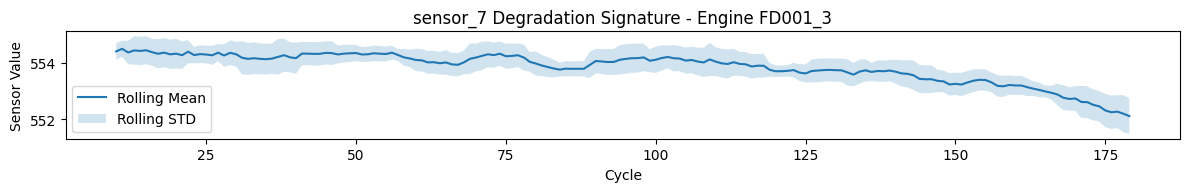

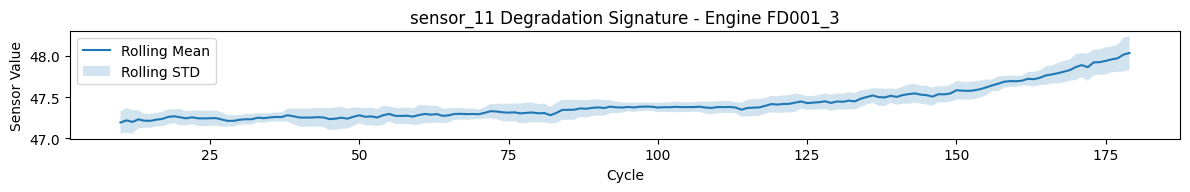

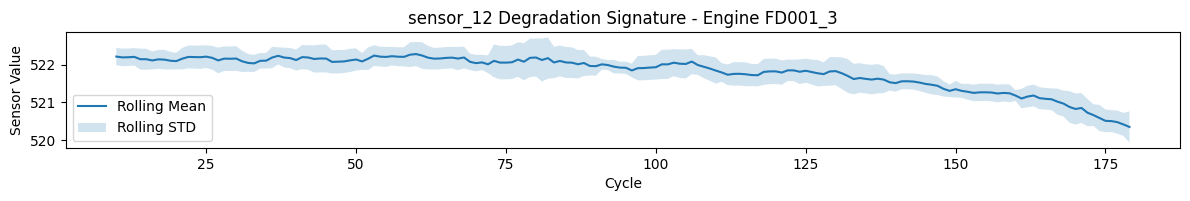

In [49]:
key_sensors = ['sensor_2', 'sensor_3', 'sensor_7', 'sensor_11', 'sensor_12']

for engine in df['engine_id'].unique()[:3]: # First 3 engines
    engine_data = df[df['engine_id'] == engine].sort_values('cycle')

    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(key_sensors):
        # Calculate rolling mean and std
        engine_data[f'{sensor}_mean'] = engine_data[sensor].rolling(window=10).mean()
        engine_data[f'{sensor}_std'] = engine_data[sensor].rolling(window=10).std()
        
        plt.subplot(len(key_sensors), 1, i+1)
        plt.plot(engine_data['cycle'], engine_data[f'{sensor}_mean'], label='Rolling Mean')
        plt.fill_between(engine_data['cycle'], engine_data[f'{sensor}_mean'] - engine_data[f'{sensor}_std'], engine_data[f'{sensor}_mean'] + engine_data[f'{sensor}_std'], alpha=0.2, label='Rolling STD')
        plt.title(f'{sensor} Degradation Signature - Engine {engine}')
        plt.xlabel('Cycle')
        plt.ylabel('Sensor Value')
        plt.legend()

        plt.tight_layout()
        plt.show()
        